<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: 2D power spectrum of an image</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Ways of estimating a PDF from some numbers
1. <a href="#fft">FFT and quick look</a>
1. <a href="#wavenumbers">Wavenumber array</a>
1. <a href="#bullseye">Low wavenumber power spectrum</a>
1. <a href="#spectrum1d">The 1D power Spectrum</a>
1. <a href="#synthetic">Synthetic images with same spectrum</a>

## Import and display an image 

In [1]:
import imageio

In [2]:
im = imageio.imread('clouds_waves.jpg')

# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

### CAREFUL! For images, the y (short) dimension appears to come first
NX = im_gray.shape[1]
NY = im_gray.shape[0]

Original image shape: (3024, 4032, 3)
New image shape: (3024, 4032)


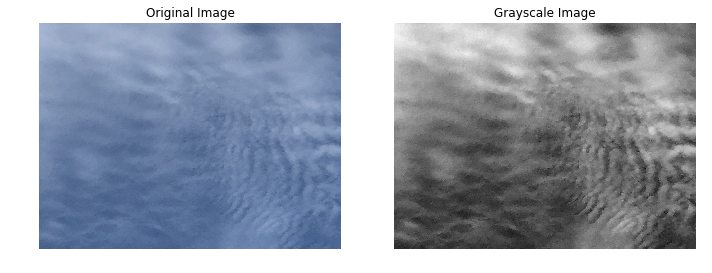

In [3]:
%matplotlib inline 

# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

<a name="fft"></a>
## FFT and a quick look  


In [4]:
from numpy import fft
import numpy as np

12192768


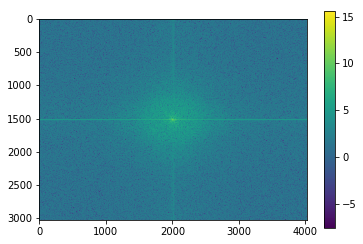

In [5]:
## Power spectrum abs(fft)
imhat = fft.fft2(im_gray)
print(np.size(imhat))
power = fft.fftshift(np.abs(imhat))

# Quick look: log, and shift origin to center of image
plt.imshow( np.log(power) ); plt.colorbar()

<a name="wavenubers"></a>
## Wavenumbers in x and y directions: 
### k, l, and total kl 

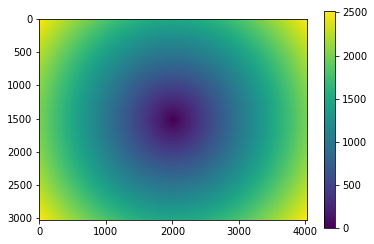

In [6]:
# Wavenumbers k, l in x,y directions: CYCLES PER DOMAIN

k = np.arange(NX) - NX/2
l = np.arange(NY) -NY/2

# Make 2D arrays of them 
kk, ll = np.meshgrid(k,l)

# Total wavenumber (distance from origin)
kl = np.sqrt(kk**2 + ll**2)
plt.imshow( kl ); plt.colorbar()

<a name="bullseye"></a>
## What we mainly see: low wavenumbers 


In [7]:
def plot_center(power, dx, dy): 

# Subset around origin 
    pow = power[ int(NY/2-dy):int(NY/2+dy), int(NX/2-dx):int(NX/2+dx) ]
    klsub = kl[ int(NY/2-dy):int(NY/2+dy), int(NX/2-dx):int(NX/2+dx) ]

# Plot
    plt.figure(figsize=(10,4))
# Image
    plt.subplot(1,2,1)
    plt.imshow(im_gray, cmap='gray')
    plt.axis('off')
    plt.title('Grayscale Image')
#Spectrum
    plt.subplot(1,2,2)
    plt.imshow( (pow), vmin=6, vmax=10 ); plt.colorbar()
    plt.set_cmap('plasma')
    plt.axis('off')
    plt.title('Low wavenumbers (contours every 5)')
    plt.contour(klsub, [5,10,15,20,25,30,35], colors='k')
    plt.tight_layout()
    plt.show()
    

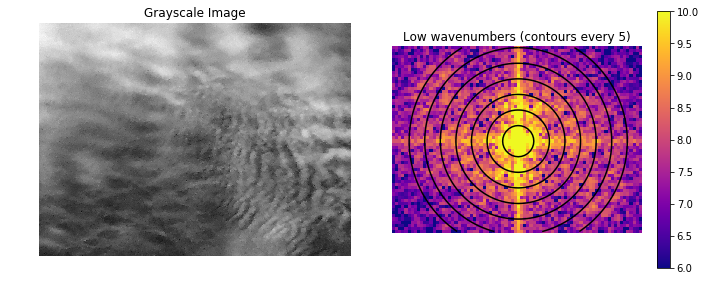

In [8]:
plot_center(np.log(power), 40, 30)

<a name="spectrum1d"></a>
## Bin the power by total wavenumber kl
### to see the orientation-independent power spectrum of the scene
Use the xarray package (with its pandas underlying "groupby" operation)

In [9]:
import xarray as xr

In [10]:
bins=np.arange(1,50) #bins for total wavenumber

In [11]:
#create a xarray data structure

xr_power = xr.DataArray(power,dims=('k', 'l'),coords={'k':l,'l':k},name='power')
xr_kl    = xr.DataArray(kl   ,dims=('k', 'l'),coords={'k':l,'l':k},name='total_wave_number')

dataset=xr.merge([xr_power,xr_kl]) #create a dataset of related variables

In [12]:
#dataset  # to see what it is

In [13]:
total_power=dataset.groupby_bins('total_wave_number',bins=bins,labels=bins[1:]).sum() # labels for each bin are, optional 
                                                                               # just makes easier for the plot below 
                                                                               # should actually be bincenters

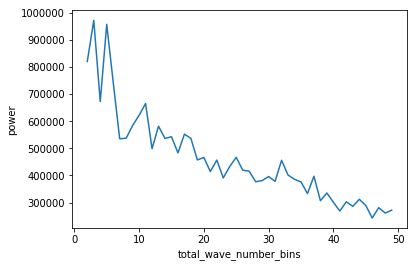

In [14]:
total_power.power.plot.line() 

--------------
<a name="synthetic"></a>
## Synthetic scenes with same power spectrum 
### Reconstruction with random phases 

In [15]:
# Reonstruct a spectrum using real and fake (random) phase info

Phase_synth = np.random.uniform(low=0, high=2*np.pi, size=np.shape(imhat))

# Phase should be symmetric as power is -- figure out how to copy it
# Phase_synth[NX/2:,:] = Phase_synth[0:NX]

imhat_synth = np.abs(imhat) * np.exp(1j*Phase_synth)

im_synth = fft.ifft2(imhat_synth).real
im_recon = fft.ifft2(imhat).real

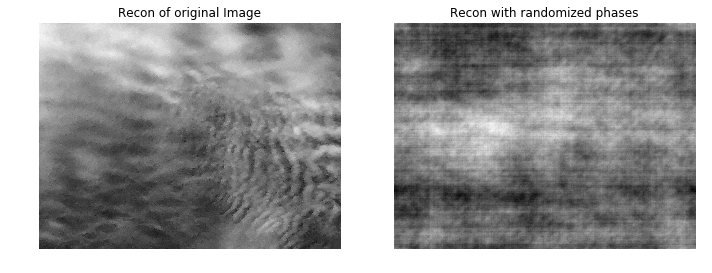

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im_recon, cmap='gray')
plt.axis('off')
plt.title('Recon of original Image')

plt.subplot(1,2,2)
plt.imshow(im_synth, cmap='gray')
plt.axis('off')
plt.title('Recon with randomized phases')

plt.tight_layout()
plt.show()